<a href="https://colab.research.google.com/github/emarkou/multilingual-bert-text-classification/blob/master/mBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [87]:
import time
import numpy as np
import pandas as pd

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertPreTrainedModel, BertModel
from transformers import get_linear_schedule_with_warmup

In [88]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [89]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU in use:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

GPU in use: Tesla T4


In [90]:
MAX_LEN = 128 # max sequences length
batch_size = 32

In [91]:
# extra preprocessing steps
# prepend CLS and append SEP, truncate, pad

labels_encoding = {
    '-1': 0,
    0: 1,
    1: 2
}

def preprocessing(df):
    sentences = df.text.values
    labels = np.array([labels_encoding[l] for l in df.target.values])

    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

    encoded_sentences = []
    for sent in sentences:
        encoded_sent = tokenizer.encode(
                            sent,
                            add_special_tokens = True,
                            truncation=True,
                            max_length = MAX_LEN
                    )

        encoded_sentences.append(encoded_sent)
    encoded_sentences = pad_sequences(encoded_sentences, maxlen=MAX_LEN, dtype="long",
                            value=0, truncating="post", padding="post")
    return encoded_sentences, labels

def attention_masks(encoded_sentences):
    # attention masks, 0 for padding, 1 for actual token
    attention_masks = []
    for sent in encoded_sentences:
        att_mask = [int(token_id > 0) for token_id in sent]
        attention_masks.append(att_mask)
    return attention_masks

In [94]:
# load the datasets
df = pd.read_csv("/kaggle/input/sentiraama-testtrain/Senti_train.csv")
df=df.dropna()
df_test = pd.read_csv("/kaggle/input/sentiraama-testtrain/Senti_test.csv")
df_test=df_test.dropna()

In [95]:
df.head()


,text,target
0,చిత్రం ఖైదీ నెంబర్ 150 నటీనటులు చిరంజీవి - క...,1
1,గత నెల ఈ పుస్తకాన్ని నేను చదివాను ఈ పుస్తకం బ...,1
2,హలో ఫ్రెండ్స్ నేను ఈ ఫోన్ ను 4 నెలల నుండి ఉపయో...,0
3,మరాఠా సామ్రాజ్యాన్ని ఏలే పేష్వాల్లో చక్రవర్తి ...,1
4,హాయ్ ఫ్రెండ్స్ ఈ ఫోన్ మంచిది కాదు కానీ ఏదో కాల...,0


In [96]:
print(df.columns)


Index(['text', 'target'], dtype='object')


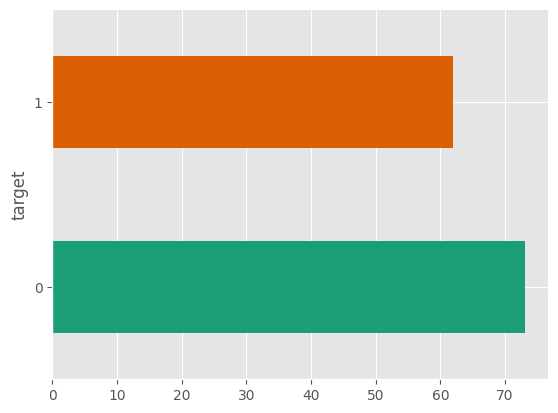

In [97]:
# @title target

from matplotlib import pyplot as plt
import seaborn as sns
df_test.groupby('target').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [98]:
train_encoded_sentences, train_labels = preprocessing(df)
train_attention_masks = attention_masks(train_encoded_sentences)

test_encoded_sentences, test_labels = preprocessing(df_test)
test_attention_masks = attention_masks(test_encoded_sentences)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [104]:
train_inputs = torch.tensor(train_encoded_sentences)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_attention_masks)

validation_inputs = torch.tensor(test_encoded_sentences)
validation_labels = torch.tensor(test_labels)
validation_masks = torch.tensor(test_attention_masks)

/tmp/ipykernel_35/1710357027.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)


In [105]:
# data loader for training
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# data loader for validation
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [106]:

import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

optimizer = AdamW(model.parameters(),
                  lr = 3e-5,
                  eps = 1e-8,
                  weight_decay = 0.01
                )

epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # 10% * datasetSize/batchSize
                                            num_training_steps = total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [107]:
import numpy as np
import torch
import time
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_accuracy(preds, labels):
    p = np.argmax(preds, axis=1).flatten()
    l = labels.flatten()
    return np.sum(p == l) / len(l)

def run_train(epochs):
    losses = []
    for e in range(epochs):
        print('======== Epoch {:} / {:} ========'.format(e + 1, epochs))
        start_train_time = time.time()
        total_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):

            if step % 10 == 0:
                elapsed = time.time() - start_train_time
                print(f'{step}/{len(train_dataloader)} --> Time elapsed {elapsed}')

            input_data = batch[0].to(device)
            input_masks = batch[1].to(device)
            input_labels = batch[2].to(device)

            model.zero_grad()

            out = model(input_data,
                        token_type_ids=None,
                        attention_mask=input_masks,
                        labels=input_labels)

            loss = out[0]
            total_loss = total_loss + loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

            optimizer.step()

        epoch_loss = total_loss / len(train_dataloader)
        losses.append(epoch_loss)
        print(f"Training took {time.time() - start_train_time}")

        # Validation
        start_validation_time = time.time()
        model.eval()
        eval_loss, eval_acc = 0, 0
        y_true, y_pred = [], []
        for step, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(device) for t in batch)
            eval_data, eval_masks, eval_labels = batch
            with torch.no_grad():
                out = model(eval_data,
                            token_type_ids=None,
                            attention_mask=eval_masks)
            logits = out[0].detach().cpu().numpy()
            labels = eval_labels.cpu().numpy()
            batch_acc = compute_accuracy(logits, labels)
            eval_acc += batch_acc

            # Append true and predicted labels for computing F1, precision, and recall
            y_true.extend(labels)
            y_pred.extend(np.argmax(logits, axis=1))

        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"Accuracy: {eval_acc / (step + 1)}, Time elapsed: {time.time() - start_validation_time}")
        print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    return losses

# Run training
epochs = 5  # or any number of epochs you want
losses = run_train(epochs)


======== Epoch 1 / 5 ========
0/17 --> Time elapsed 0.003914356231689453
10/17 --> Time elapsed 6.327438831329346
Training took 10.638121843338013


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.49910714285714286, Time elapsed: 0.8368258476257324
Precision: 0.21091906721536352, Recall: 0.45925925925925926, F1 Score: 0.2890768941530363
======== Epoch 2 / 5 ========
0/17 --> Time elapsed 0.002638101577758789
10/17 --> Time elapsed 6.361030101776123
Training took 10.747716903686523
Accuracy: 0.6178571428571429, Time elapsed: 0.8513445854187012
Precision: 0.7862068965517242, Recall: 0.6, F1 Score: 0.5432828529555448
======== Epoch 3 / 5 ========
0/17 --> Time elapsed 0.0022995471954345703
10/17 --> Time elapsed 6.470386028289795
Training took 10.930740356445312
Accuracy: 0.6178571428571429, Time elapsed: 0.8760786056518555
Precision: 0.7862068965517242, Recall: 0.6, F1 Score: 0.5432828529555448
======== Epoch 4 / 5 ========
0/17 --> Time elapsed 0.002290964126586914
10/17 --> Time elapsed 6.518726825714111
Training took 10.97718620300293
Accuracy: 0.6892857142857143, Time elapsed: 0.8670649528503418
Precision: 0.7591814579601585, Recall: 0.7111111111111111, F1 Score: 0

In [102]:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

def compute_accuracy(preds, labels):
    p = np.argmax(preds, axis=1).flatten()
    l = labels.flatten()
    return np.sum(p==l)/len(l)

def run_train(epochs):
    losses = []
    for e in range(epochs):
        print('======== Epoch {:} / {:} ========'.format(e + 1, epochs))
        start_train_time = time.time()
        total_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):

            if step%10 == 0:
                elapsed = time.time()-start_train_time
                print(f'{step}/{len(train_dataloader)} --> Time elapsed {elapsed}')

            # input_data, input_masks, input_labels = batch
            input_data = batch[0].to(device)
            input_masks = batch[1].to(device)
            input_labels = batch[2].to(device)

            model.zero_grad()

            # forward propagation
            out = model(input_data,
                        token_type_ids = None,
                        attention_mask = input_masks,
                        labels = input_labels)

            loss = out[0]
            total_loss = total_loss + loss.item()

            # backward propagation
            loss.backward()

            torch.nn.utils.clip_grad_norm(model.parameters(), 1)

            optimizer.step()

        epoch_loss = total_loss/len(train_dataloader)
        losses.append(epoch_loss)
        print(f"Training took {time.time()-start_train_time}")

        # Validation
        start_validation_time = time.time()
        model.eval()
        eval_loss, eval_acc = 0,0
        for step, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(device) for t in batch)
            eval_data, eval_masks, eval_labels = batch
            with torch.no_grad():
                out = model(eval_data,
                            token_type_ids = None,
                            attention_mask=eval_masks)
            logits = out[0]

            #  Uncomment for GPU execution
            logits = logits.detach().cpu().numpy()
            eval_labels = eval_labels.to('cpu').numpy()
            batch_acc = compute_accuracy(logits, eval_labels)

            # Uncomment for CPU execution
            # batch_acc = compute_accuracy(logits.numpy(), eval_labels.numpy())

            eval_acc += batch_acc
        print(f"Accuracy: {eval_acc/(step+1)}, Time elapsed: {time.time()-start_validation_time}")
    return losses


In [103]:
losses = run_train(epochs)

======== Epoch 1 / 3 ========
0/17 --> Time elapsed 0.0024709701538085938


/tmp/ipykernel_35/2688905261.py:40: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1)


10/17 --> Time elapsed 6.448284149169922
Training took 10.73873496055603
Accuracy: 0.49910714285714286, Time elapsed: 0.819378137588501
======== Epoch 2 / 3 ========
0/17 --> Time elapsed 0.002361774444580078
10/17 --> Time elapsed 6.282355070114136
Training took 10.608213663101196
Accuracy: 0.6178571428571429, Time elapsed: 0.8357329368591309
======== Epoch 3 / 3 ========
0/17 --> Time elapsed 0.0022003650665283203
10/17 --> Time elapsed 6.393398284912109
Training took 10.791677713394165
Accuracy: 0.6178571428571429, Time elapsed: 0.8489930629730225


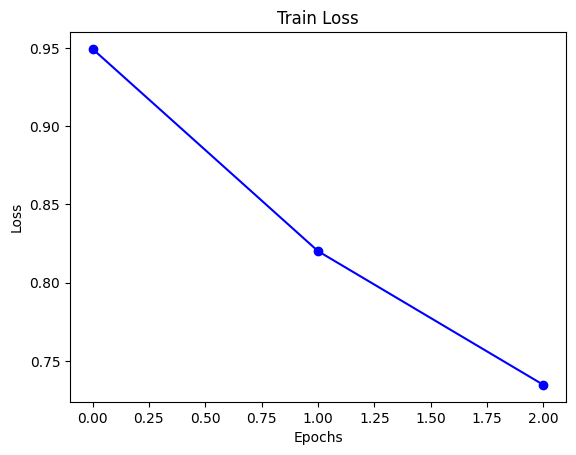

In [37]:
 # plot losses
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

plt.plot(losses, 'b-o')
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [40]:
def run_test(df_test):

    test_encoded_sentences, test_labels = preprocessing(df_test)
    test_attention_masks = attention_masks(test_encoded_sentences)

    test_inputs = torch.tensor(test_encoded_sentences)
    test_labels = torch.tensor(test_labels)
    test_masks = torch.tensor(test_attention_masks)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    model.eval()
    eval_loss, eval_acc = 0,0
    for step, batch in enumerate(test_dataloader):
        batch = tuple(t.to(device) for t in batch)
        eval_data, eval_masks, eval_labels = batch
        with torch.no_grad():
            out = model(eval_data,
                        token_type_ids = None,
                        attention_mask=eval_masks)
        logits = out[0]
        logits = logits.detach().cpu().numpy()
        eval_labels = eval_labels.to('cpu').numpy()
        batch_acc = compute_accuracy(logits, eval_labels)
        eval_acc += batch_acc
    print(f"Accuracy: {eval_acc/(step+1)}")

In [41]:
run_test(df_test)

Accuracy: 0.6514001623376624
